# Table of Contents
- ### [Environment Setup](#env)
- ### [Data Preparation and Transformation](#prep)
- ### [Exploratory Data Analysis](#anly)
  - #### [Variable Distribution](#vard)
  - #### [Predictor and Response Variable Relation](#varr)
  - #### [Variable Correlation](#varc)
  - #### [Outlier Analysis](#outl)
- ### [Linear Regression](#reg)
  - #### [Single Predictor](#sinp)
  - #### [Multiple Predictors](#mulp)
  - #### [Multiple Predictor with an Interaction Term](#mpi)
- ### [Summary](#sumy)

<a id="env"></a>
# Environment Setup

This notebook is written in the following environment:

- macOS Monterey 12.4
- Jupyter notebook server version 6.4.5
- Python 3.9.7

The following Python libraries are used:
- `pandas`: 1.3.4
- `numpy`: 1.20.3
- `scikit-learn`: 0.24.2
- `statsmodels`: 0.12.2
- `matplotlib`: 3.4.3
- `scipy`: 1.7.1 
- `seaborn`: 0.11.2

In [110]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<a id="prep"></a>
# Data Preparation and Transformation

First, let's read the dataset from the file "data.txt" which should be in the same directory as this notebook.

Note that I used a special encoding when reading the file because the file encoding is not compatible with the default encoding of my environment.

In [111]:
input_df = pd.read_csv("data.txt", sep = "|", encoding='iso-8859-1')

In [112]:
input_df.head()

,,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115


In the input file, the values of data for all the fields are all in the column "value" and the marking of which variables the entries belong in are in the column "variables".

We need to transform the data so that we have the same number of columns as the number of variables there are, and each column contains values of each variable, as this is the shape that it needs to be in to do analysis and regression on easily.

Before we do so, we need to define the schema of the name and datatype we want to assign to the variables.


Here are the data labels for the original inputs:

    i - mother's IQ as float
    
    a - mother's age at child's birth as integer
    
    h - indicator showing whether mother completed high school (1=True, 0=False) as integer
    
    w1 - mother did not work in first three years of child’s life as integer
    
    w2- mother worked in second or third year of child’s life as integer
    
    w3- mother worked part-time in first year of child’s life as integer
    
    w4- mother worked full-time in first year of child’s life as integer
    
    score - child's IQ (regressand) as integer
    
Here is how I choose the variable types and the names of the variables to be descriptive of the data:

    i -> IQ         (float)
    a -> age        (integer)
    h -> education  (integer)
    w -> work       (integer)
    score -> score  (float)

We know we will be performing linear regression for this exercise. The education variable `h` is binary, and thus should be cast as an integer to be usable as a feature for the models. Similarly, the work variable `w` is categorical, and should be flattened into four binary dummy variables `w1`, `w2`, `w3`, and `w4` before being used as features for linear regression. For now, I will also keep the original variable `w` for observation.

Now that we have decided on a schema, I will first isolate each variable into its own pandas series:

In [113]:
score = input_df.loc[input_df['variable'] =='score']['value'].astype('int')
a = input_df.loc[input_df['variable'] =='a']['value'].astype('int')
h = input_df.loc[input_df['variable'] =='h']['value'].astype('int')
w = input_df.loc[input_df['variable'] =='w']['value'].astype('int')
i = input_df.loc[input_df['variable'] =='i']['value'].str.replace("'","").astype('float')

Next we create a dataframe and put all the variable columns in it.

In [114]:
df = pd.DataFrame()

df['score'] = score.values
df['IQ'] = i.values
df['age'] = a.values
df['education'] = h.values
df['work'] = w.values

And this is what our working dataframe looks like:

In [115]:
df.head()

,score,IQ,age,education,work
0,65,121.117529,27,1,4
1,98,89.361882,25,1,4
2,85,115.443165,27,1,4
3,83,99.449639,25,1,3
4,115,92.745710,27,1,4


<a id="anly"></a>
# Exploratory Data Analysis
The first step to building a model is to look at what information we can gather from the data. This section shows us what the data look like visually and what we can observe by looking at them.

<a id="vard"></a>
## Variable Distribution
Let us first look at the distribution of each variable.

Mean of child's IQ:  86.79723502304148


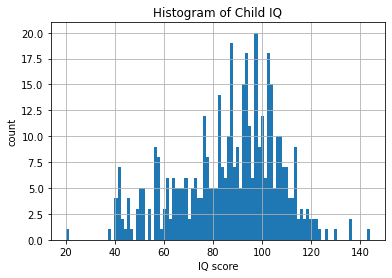

In [116]:
plt.title('Histogram of Child IQ')
plt.xlabel('IQ score')
plt.ylabel('count')
df.score.hist(bins=100)
print("Mean of child's IQ: ",df.score.mean())

*Most of the children's test score revolve around 87, with fat tail at the lower end.*

Mean of mother's IQ:  99.99999999999999


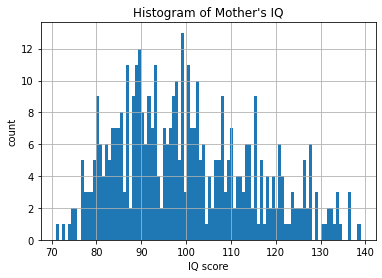

In [117]:
plt.title("Histogram of Mother's IQ")
plt.xlabel('IQ score')
plt.ylabel('count')

df.IQ.hist(bins=100)
print("Mean of mother's IQ: ",df.IQ.mean())

*Mothers' IQ somewhat congregate around 100, with fat tail on the higher end.*

Mean of mother's age:  22.785714285714285


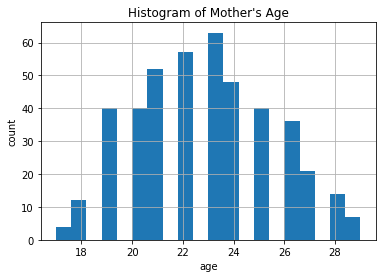

In [118]:
plt.title("Histogram of Mother's Age")
plt.xlabel('age')
plt.ylabel('count')

df.age.hist(bins=20)
print("Mean of mother's age: ",df.age.mean())

*Mother's age slightly congregate around 23, the distribution look mostly normal.*

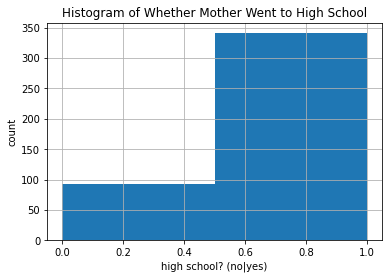

In [119]:
plt.title("Histogram of Whether Mother Went to High School")
plt.xlabel('high school? (no|yes)')
plt.ylabel('count')

df.education.hist(bins=2)

*There are about 22% of mothers who did not complete high school and the rest did.*

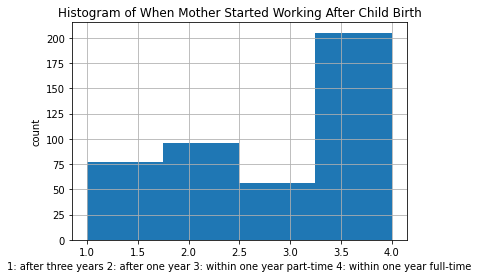

In [120]:
plt.title('Histogram of When Mother Started Working After Child Birth')
plt.xlabel('1: after three years 2: after one year 3: within one year part-time 4: within one year full-time')
plt.ylabel('count')
df.work.hist(bins=4)

*Mothers worked full-time in the first year of child's life the most.*

<a id="varr"></a>
## Predictor and Response Variable Relation

Now let's look at how the response variable moves with each predictor.

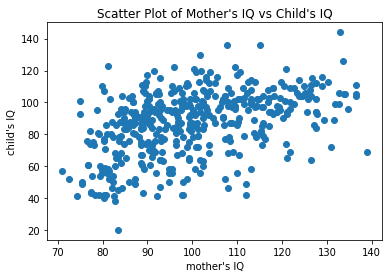

In [121]:
plt.title("Scatter Plot of Mother's IQ vs Child's IQ")
plt.xlabel("mother's IQ")
plt.ylabel("child's IQ")

plt.scatter(df['IQ'],df['score'])

Looks like there might be a *slight upward trend between mother's IQ score and the child's IQ score*, but the relationship is only mildly clear from the graph.

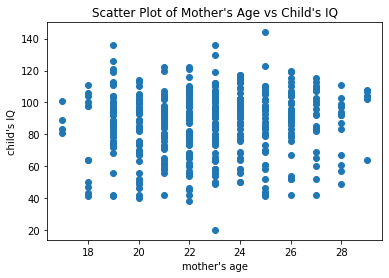

In [122]:
plt.title("Scatter Plot of Mother's Age vs Child's IQ")
plt.xlabel("mother's age")
plt.ylabel("child's IQ")
plt.scatter(df['age'],df['score'])

There does not appear to be an apparent relationship between mother's age and the child's IQ, or perhaps it is hard to see because we have less samples on both tail ends of the mother's age.

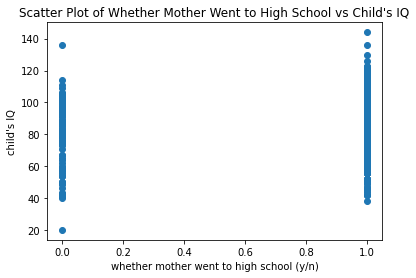

In [123]:
plt.title("Scatter Plot of Whether Mother Went to High School vs Child's IQ")
plt.xlabel("whether mother went to high school (y/n)")
plt.ylabel("child's IQ")
plt.scatter(df['education'],df['score'])

Looks like *most of the children with very high IQ (above 118) have mothers who went to high school*. In the more common ranges of IQ, mother's IQ doesn't appear to be very significant.

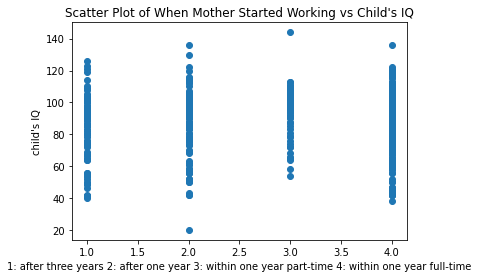

In [124]:
plt.title("Scatter Plot of When Mother Started Working vs Child's IQ")
plt.xlabel("1: after three years 2: after one year 3: within one year part-time 4: within one year full-time")
plt.ylabel("child's IQ")
plt.scatter(df['work'],df['score'])

From the more common range of child's IQ, we do not see significance of when mother started working from the plot, and we cannot make any conclusions outside of that range because of the lack of data.

<a id="varc"></a>
## Variable Correlation
Let's now see the correlation between the possible features and the result variable `score` to see how closely all the variables follow each other.

In this heatmap, the more blue the color means the stronger positive correlation, and the more yellow the color means the stronger negative correlation. The blocks closer to green suggests the least correlation.

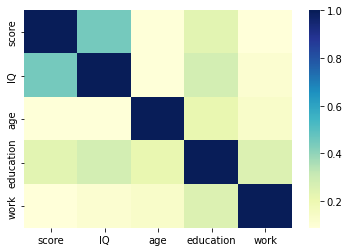

,score,IQ,age,education,work
score,1.000000,0.448276,0.091998,0.236916,0.087528
IQ,0.448276,1.000000,0.091608,0.282709,0.114803
age,0.091998,0.091608,1.000000,0.214528,0.135598
education,0.236916,0.282709,0.214528,1.000000,0.253910
work,0.087528,0.114803,0.135598,0.253910,1.000000


In [125]:
corr = df.corr()
ax = sns.heatmap(corr, cmap = "YlGnBu")
plt.show()
corr

From the correlation matrix, it appears that the *mother's IQ has the most correlation to the child's IQ*. No other parameters seem to be highly correlated, which means that they are all quite independent from each other.

<a id="outl"></a>
## Outlier Analysis

Before building our model, we need to remove the outlier cases. Let's take a look at the distribution of the child's test score again:

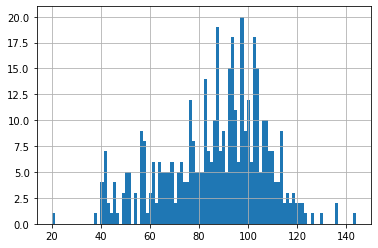

In [126]:
df.score.hist(bins=100)

In [127]:
df.score.describe()

count    434.000000
mean      86.797235
std       20.410688
min       20.000000
25%       74.000000
50%       90.000000
75%      102.000000
max      144.000000
Name: score, dtype: float64

As we have observed above in exploratory data analysis, it is very hard to tell the effects of the predictor from the graphs at the extreme ends of the spectrum for child's IQ score, because the sample size is so little.

Therefore we should consider removing those data points because those outlier data would not be useful in determining the trend without enough neighboring data, and the outliers can possibly generate extra noise and biases in the models as well.

We can decide the range in which the data points are common enough by taking the range of two standard deviations around the mean:

In [128]:
print("The range of data within 2 standard deviations of the mean is ",(df.score.mean()-2*df.score.std())," to ",(df.score.mean()+2*df.score.std()))

The range of data within 2 standard deviations of the mean is  45.97585803458711  to  127.61861201149586


This is a pretty reasonable range for the child's IQ score in which we can promise with some certainty that our predictions trained using this dataset will not be out of wack, because the data within this range appears commonly enough in the dataset.

Let us go ahead and remove entries that are out of this range.

In [129]:
df = df[np.abs(df.score - df.score.mean()) <= (2*df.score.std())]

Now our result variable data looks like this: 


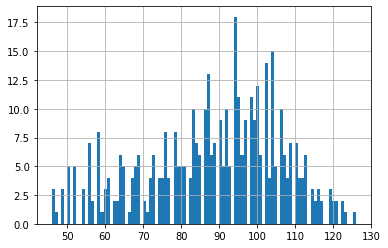

In [130]:
df.score.hist(bins=100)
print("Now our result variable data looks like this: ")

As you can see, we have removed a few entries from the dataset on the tail ends of the distribution, but the vast majority of the data stays.

The last thing we need to do before starting to build models is to flatten the category variables into dummy variables as I promised earlier.

In [131]:
dummies = pd.get_dummies(df['work']).rename(columns=lambda x: 'w'+str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(['work'], inplace=True, axis=1)

And this is what our final working dataset to perform regression on looks like:

In [132]:
df.head()

,score,IQ,age,education,w1,w2,w3,w4
0,65,121.117529,27,1,0,0,0,1
1,98,89.361882,25,1,0,0,0,1
2,85,115.443165,27,1,0,0,0,1
3,83,99.449639,25,1,0,0,1,0
4,115,92.745710,27,1,0,0,0,1


<a id="reg"></a>
# Linear Regression
In this section, we perform linear regression:

- using a single predictor

- using multiple predictors

- using multiple predictors with an interaction term

In [133]:
X = df[['IQ','age','education','w1','w2','w3','w4']]
y = df['score']

<a id="sinp"></a>
## Single Predictor

The first models that we build are single predictor linear regressions that should give us some good information about the predictive power of each predictor. 

We take the training set of the predictors `IQ`, `age`, `education`, `w1`, `w2`, `w3`, and `w4` to regress with the result variable `score` individually and gets scores on the testing set.

A seed is set for the train test split to make the R-squared scores consistent for model comparison.

The scores for each regression is collected and presented as a bar graph to compare the accuracy of models using each feature.

In [134]:
def LinearModel(X_lin, Y_lin):
    X_train, X_test, y_train, y_test = train_test_split(X_lin,Y_lin, train_size = 0.8, random_state = 15)
    
    reg = linear_model.LinearRegression()
    reg.fit(X_train,y_train)

    prediction = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    return score

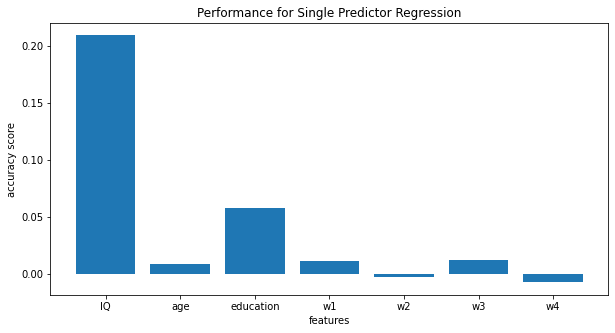

In [135]:
vars = list(X.columns.values)
results = []

for col in X:
  score = LinearModel(X[[col]],y)
  results.append(score)

fig = plt.figure(figsize = (10,5))
plt.bar(vars, results)
plt.xlabel("features")
plt.ylabel("accuracy score")
plt.title("Performance for Single Predictor Regression")
plt.show()

*Looks like single predictor model using IQ is significantly more accurate that single predictor model using other features*, and therefore we would choose this model as the best single predictor model.

In [136]:
LinearModel(X[['IQ']],y)

0.2093783598185781

However even the best single predictor model does not perform very well, sitting at the accuracy of around 0.21.

Let us see if the performance can be better when we regress with multiple predictors.

<a id="mulp"></a>
## Multiple Predictors

Before making conclusions about which features we should include to get the best model, we need to do an OLS regression of all the features to figure out which features are significant when put alongside with all other features.

In [137]:
model_all = sm.OLS(y, sm.add_constant(X)).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     14.25
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           9.45e-15
Time:                        22:22:23   Log-Likelihood:                -1738.7
No. Observations:                 413   AIC:                             3491.
Df Residuals:                     406   BIC:                             3520.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3062      6.956      3.926      0.0

This is pretty interesting result, because during single predictor regression, `education` provides the second best result after `IQ`. 

However in this multiple predictor regression, `education` is the second worst feature after `age` based on the p-value, and does not even pass the two-tail test since its p-value is higher than 0.025.

On the contrary, `w2`, and `w3` show statistical significance.

This descrepency says that `education` works better alone, but perhaps gets 'explained away' by other variables. On the contrary, `w2` and `w3` works better alongside with other variables, suggesting their strength of interacting terms.

Now we need to try to figure out;

1. which term 'explains away' the effects of `education`

2. which terms interact well with `w2` and `w3`

Here are some sets of parameters we can try to figure out the two questions:

    Question 1: which term 'explains away' the effects of education?

    Model 1a: education + IQ

    Model 1b: education + age

    Model 1c: education + w1 + w2 + w3 + w4


    Question 2: which terms interact well with w2 and w3?

    Model 2a: w1 + w2 + w3 + w4 + IQ

    Model 2b: w1 + w2 + w3 + w4 + age

    Model 2c: w1 + w2 + w3 + w4 + education

For Model 1c, I put all the work dummy variables together because the effects of those terms should not be separate from each other.

For the second question, I will not attempt dummy variables with other dummy variables because they should not be interacting with each other at all due to the mutually exclusive relationship, and put `w2` and `w3` in the same models for the same reason.

In [138]:
model_1a = sm.OLS(y, sm.add_constant(X[['IQ','education']])).fit()
print(model_1a.summary())

model_1b = sm.OLS(y, sm.add_constant(X[['age','education']])).fit()
print(model_1b.summary())

model_1c = sm.OLS(y, sm.add_constant(X[['education','w1','w2','w3','w4']])).fit()
print(model_1c.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     41.54
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           3.73e-17
Time:                        22:22:23   Log-Likelihood:                -1740.0
No. Observations:                 413   AIC:                             3486.
Df Residuals:                     410   BIC:                             3498.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7112      5.537      6.992      0.0

*It looks pretty apparent from the three models above that `education` is explained away by `IQ`*, since that is the only model in which the p-value of `education` did not pass the significance test.

In [139]:
model_2a = sm.OLS(y, sm.add_constant(X[['IQ','w1','w2','w3','w4']])).fit()
print(model_2a.summary())

model_2b = sm.OLS(y, sm.add_constant(X[['age','w1','w2','w3','w4']])).fit()
print(model_2b.summary())

model_2c = sm.OLS(y, sm.add_constant(X[['education','w1','w2','w3','w4']])).fit()
print(model_2c.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     20.71
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           1.49e-15
Time:                        22:22:23   Log-Likelihood:                -1740.0
No. Observations:                 413   AIC:                             3490.
Df Residuals:                     408   BIC:                             3510.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.0082      4.514      7.091      0.0

Because the dummy variable only gives us 0 and 1 values, the way that we should compare models is how much performance they amplify on individual variables.

The accuracy for `IQ`, `age`, and `education` as stand-alone variables are: 0.209, 0.008, and 0.058 respectively.

The accuracies including the work variables are 0.169, 0.021, and 0.040. 

Therefore, we can conclude that *the dummy variables for `work` and `age` interact with each other exceptionally well, while the predictive power of `IQ` and `education` are slightly reduced*.

Based on the conclusions we have made, we are going to exclude education because it gets explained away by `IQ` a lot, and also keep the `age` and `work` dummy variables.

In [140]:
LinearModel(X[['IQ','age','w1','w2','w3','w4']], y)

0.22483853356178674

Our model of choice for the multiple predictor model performs only slightly better than the single predictor model, which demonstrates how dominant the `IQ` variable is.

<a id="mpi"></a>
## Multiple Predictors with Interaction an Term

Since we have concluded above that `age` and the `work` dummy variables interaact well together, let us see which value for `work` gives the best interaction term if we have to choose one.

In [141]:
X_interactions = X.copy()

X_interactions['age_w1'] = X['age']*X['w1']
X_interactions['age_w2'] = X['age']*X['w2']
X_interactions['age_w3'] = X['age']*X['w3']
X_interactions['age_w4'] = X['age']*X['w4']

model_interactions = sm.OLS(y, sm.add_constant(X_interactions)).fit()
print(model_interactions.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     10.09
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           4.90e-14
Time:                        22:22:23   Log-Likelihood:                -1736.2
No. Observations:                 413   AIC:                             3492.
Df Residuals:                     403   BIC:                             3533.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2221      7.503      4.028      0.0

The interaction terms do not look like they are working very well, because there are possible nuances between the terms.

It looks like `age` is even less relavent when we add the interaction terms and the interaction terms have mixed results in terms of its significance.

Because `age` is already pretty insignificant in the model with all features without any interaction terms, the effects of other variables might be dominating the behaviors of this features, making it hard to tell whether our observations are valid.

Overall, all the interaction terms have proven to be insignificant. This is possibly due to age also getting explained away by when the mother starts working.

Depending on what age the mothers are, how long they usually choose to start working after childbirth are different.

Nontheless, the interaction term between `age` and `w1` appears to be the most significant amongst the interaction terms, let us see how it performs if we only include this interaction term.

In [142]:
X_w1 = X.copy()
X_w1['age_w1'] = X['age']*X['w1']

LinearModel(X_w1, y)

0.22829712340315444

Looks like including this interaction term does make a small improvement from our multiple predictor model of choice without any interaction term!

I suspect that the effect of this interaction term is not very potent because the feature `IQ` is so dominating of the whole model, that we should also examine the interaction terms surroounding this variable in the future.

<a id="sumy"></a>
# Summary

In this notebook, we parsed and transfored the dataset, made observations about the data, and performed linear regression with single predictor, multiple predictors, and then incorperated interaction terms with multiple predicotors.

We have concluded that `IQ` is the strongest stand-alone feature amongst all the features, the effect of `education` seems to be explained away by `IQ`, and that `age` can interact well `w1`.

Some future work can be done to make the model for this dataset better, including exploring the effects of more interaction terms, even interaction terms with more than two variables because semantically, the features that we have seem to have some causation and effect correlations with each other. More importantly, we should consider exploring all the possibilities surrounding `IQ` because its effect dominates the model significantly.